## Best subset linear regression problem

In [1]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def f(z,t):
    X =t[0]
    y = t[1]
    lam = t[2]
    Xt = X[:,z==1]
    if z.sum() > 0:
        reg = LinearRegression().fit(Xt,y).predict(Xt)
    else:
        reg = np.zeros(y.shape[0])
    RMSE_term = ((y - reg)**2).sum()
    L0_term = lam*(z.sum())
    loss = (RMSE_term + L0_term) / y.shape[0]
    return loss


In [3]:
def sampleDisARM(theta,f,t):
    pnum = theta.shape[0]
    u = np.random.uniform(size= pnum) # should be p and not K
    #z = np.array([1.0 if u[j] < theta[j] else 0.0 for j in range(K)])
    #ztilde = np.array([1.0 if 1.0 - u[j] < theta[j] else 0.0 for j in range(K)])
    z = (u < theta).astype(int)
    ztilde = (1.0 - u < theta).astype(int)
    loss = f(z,t)
    diff = loss - f(ztilde,t)
    
    g = np.zeros(pnum)
    g[theta < 0.5] = 0.5*diff*((-1)**(ztilde[theta<0.5]))*(1/theta[theta<0.5])
    g[theta >= 0.5] = 0.5*diff*((-1)**(ztilde[theta>=0.5]))*(1/(1.0 - theta[theta>=0.5]))
    g[ztilde == z] = 0 
    
    return g, loss
    
def sampleBitFlip_1(theta,f,t):
    pnum = theta.shape[0]
    q = np.random.choice(list(range(pnum)))
    z = np.random.binomial(n=1, p = theta)
    g = np.zeros(pnum)
    z_copy = z.copy()
    z[q] = 1
    z_copy[q] = 0
    loss = f(z,t)
    g[q] = pnum*(loss - f(z_copy,t))
    return g, loss

def sampleBitFlip_k(theta, f,t):
    pnum = theta.shape[0]
    z = np.random.binomial(n=1, p = theta)
    g = np.zeros(pnum)
    
    loss = 0
    for i in range(pnum):
        z_copy = z.copy()
        z_copy2 = z.copy()
        z_copy[i] = 1
        z_copy2[i] = 0
        if i==0:
            loss += f(z_copy,t)
            g[i] = (loss - f(z_copy2,t))
        else:
            g[i] = (f(z_copy,t) - f(z_copy2,t))
        
    return g, loss


def sampleBitFlip_opt(theta,f,t):
    pnum = theta.shape[0]
    g_1, loss = sampleBitFlip_1(theta,f,t) 
    g_2, loss2 = sampleDisARM(theta,f,t)
    use_bitflip = 1/np.min(np.array([theta,1-theta]), axis = 0) >= 3.0 # shouldn't this be >= 2K or something according to the paper?
    g = np.zeros(pnum)
    g[use_bitflip] = g_1[use_bitflip]
    g[~use_bitflip] = g_2[~use_bitflip]
    return g, loss


def sampleReinforce_loo(theta,f,t):
    z1 = np.random.binomial(n=1, p = theta)
    z2 = np.random.binomial(n=1, p = theta)
    f1 = f(z1,t)
    f2 = f(z2,t)
    return 0.5 * ((f1 - f2) * (z1 - theta)+ (f2 - f1) * (z2 - theta)) *(1/theta)*(1/(1-theta)), f1

# def loss(theta, t, K):
#     """ 
#     K is monte carlo samples 
#     """
#     loss = 0
#     for _ in range(K):
#         z = np.random.binomial(n=1, p = theta)
#         loss = loss + f(z,t)

#     return loss/K
def loss_fun(theta, t, K):
    """ 
    K is monte carlo samples 
    """
    X =t[0]
    y = t[1]
    lam = t[2]
    
    loss = 0
    for _ in range(K):
        z = np.random.binomial(n=1, p = theta)
        Xt = X[:,z==1]
        if z.sum() > 0:
            reg = LinearRegression().fit(Xt,y).predict(Xt)
        else:
            reg = np.zeros(y.shape[0])
        RMSE_term = ((y - reg)**2).sum()
        L0_term = lam*(z.sum())
        loss += RMSE_term / y.shape[0] + L0_term

    return loss/K

In [4]:
def inverse_sigma(y):
    y = np.asarray(y, dtype=float)
    result = np.empty_like(y)
    
    # Create masks
    zero_mask = y <= 0.0
    one_mask = y >= 1.0
    valid_mask = ~(zero_mask | one_mask)
    
    # Assign values only where needed
    result[zero_mask] = -np.inf
    result[one_mask] = np.inf
    if np.any(valid_mask):
        result[valid_mask] = np.log(y[valid_mask] / (1 - y[valid_mask]))
    
    return result

def sigma(x):
    result = np.empty_like(x)
    
    inf_mask = x == np.inf
    valid_mask = ~inf_mask
    
    result[inf_mask] = np.float64(1)
    result[valid_mask] = np.exp(x[valid_mask]) / (1 + np.exp(x[valid_mask]))
    
    return result

def train3(grad_func, start, t, n_epoch = 1000, learning_rate = 0.1, K=1):
    
    losses = []
    thetas = []
    vars_ = []
    phi = inverse_sigma(start)
    
    for _ in tqdm(range(n_epoch)):
        theta = sigma(phi)
        gradients = []
        loss_avg = 0
        for _ in range(K):
            gradient, loss = grad_func(theta, f, t)
            gradients.append(gradient)
            loss_avg += loss
        loss_avg = loss_avg / K
        g = np.mean(gradients, axis=0)  # Average across samples
        vars_.append(np.var(gradients, axis = 0).mean())
            
        phi = phi - learning_rate*g*sigma(phi)*sigma(-1.0*phi)
        
        thetas.append(theta)
        losses.append(loss_fun(theta, t, 1))
        # losses.append(loss_avg)
    return thetas, losses, np.array(vars_)

def train2(grad_func,start, t, n_epoch = 1000, learning_rate = 0.1, K=1):
    
    losses = []
    thetas = []
    vars_ = []
    theta = start
    
    for i in tqdm(range(n_epoch)):
        theta[theta < 0] = 10e-12
        theta[theta > 1] = 1 - 10e-12
        
        # compute variances:
        g_ss = []
        for j in range(K):
            g_s, _ = grad_func(theta, f, t)
            g_ss.append(g_s)
        g_ss = np.array(g_ss)
        vars_.append(np.var(g_ss, axis = 0).mean())
        
        g, _ = grad_func(theta, f, t)
        theta = theta - learning_rate*g#*sigma(phi)*sigma(-1.0*phi)
        
        theta[theta < 0] = 10e-12
        theta[theta > 1] = 1 - 10e-12
        thetas.append(theta)
        losses.append(loss_fun(theta, t, K))
    return thetas, losses, np.array(vars_)

def train(grad_func,start, t, n_epoch = 1000, learning_rate = 0.1, K=1):
    
    losses = []
    thetas = []
    vars_ = []
    theta = start
    
    theta[theta <= 0] = 10e-12
    theta[theta >= 1] = 1 - 10e-12
    
    for i in tqdm(range(n_epoch)):
        
        # compute gradients, losses and variance simultaneously
        gradients = []
        loss_avg = 0
        
        for _ in range(K):
            gradient, loss = grad_func(theta, f, t)
            gradients.append(gradient)
            loss_avg += loss
        loss_avg = loss_avg / K
        g = np.mean(gradients, axis=0)  # Average across samples
        
        vars_.append(np.var(gradients, axis = 0).mean())
        
        theta = theta - learning_rate*g
        # np.clip(theta, 0, 1, out=theta)
        theta[theta <= 0] = 10e-12
        theta[theta >= 1] = 1 - 10e-12

        thetas.append(theta)
        losses.append(loss_fun(theta, t, 1))
    return thetas, losses, np.array(vars_)

## Train

In [5]:
import pandas as pd
from time import time
import pickle

In [69]:
X = pd.read_csv("./results/EGP_2_2025-08-20__n_200__p_2000__s_30__noise_0.75__lambda_15.0__lr_0.1__seed_1__initp_0.5__optimizer_Descent__X.csv")
y = pd.read_csv("./results/EGP_2_2025-08-20__n_200__p_2000__s_30__noise_0.75__lambda_15.0__lr_0.1__seed_1__initp_0.5__optimizer_Descent__y.csv")
EGP_metrics = pd.read_csv("./results/EGP_2_2025-08-20__n_200__p_2000__s_30__noise_0.75__lambda_15.0__lr_0.1__seed_1__initp_0.5__optimizer_Descent__metrics.csv")
actual_beta = pd.read_csv("./results/EGP_2_2025-08-20__n_200__p_2000__s_30__noise_0.75__lambda_15.0__lr_0.1__seed_1__initp_0.5__optimizer_Descent__actual_beta.csv")
setting = pd.read_csv("./results/EGP_2_2025-08-20__n_200__p_2000__s_30__noise_0.75__lambda_15.0__lr_0.1__seed_1__initp_0.5__optimizer_Descent__setting.csv")
l_e_descent = pd.read_csv("./results/EGP_2_2025-08-20__n_200__p_2000__s_30__noise_0.75__lambda_15.0__lr_0.1__seed_1__initp_0.5__optimizer_Descent__EGP_results.csv")

In [70]:
EGP_metrics_adam = pd.read_csv("./results/EGP_2_2025-08-20__n_200__p_2000__s_30__noise_0.75__lambda_15.0__lr_0.1__seed_1__initp_0.5__optimizer_Adam__metrics.csv")
l_e = pd.read_csv("./results/EGP_2_2025-08-20__n_200__p_2000__s_30__noise_0.75__lambda_15.0__lr_0.1__seed_1__initp_0.5__optimizer_Adam__EGP_results.csv")
EGP_metrics_std_adam = pd.read_csv("./results/EGP_2_2025-08-20__n_200__p_2000__s_30__noise_0.75__lambda_15.0__lr_0.1__seed_1__initp_0.5__optimizer_Adam__metrics_std.csv")
EGP_metrics_std = pd.read_csv("./results/EGP_2_2025-08-20__n_200__p_2000__s_30__noise_0.75__lambda_15.0__lr_0.1__seed_1__initp_0.5__optimizer_Descent__metrics_std.csv")


In [71]:
n, p, p_sub, noise, lambda_, lr, seed, initp, optimizer = setting.values[0]

In [72]:
X = np.array(X)
y = np.array(y).flatten()
actual_beta = np.array(actual_beta).flatten()
start = np.array([initp]*p)
t = [X,y,lambda_]
l_e_descent = np.array(l_e_descent)
l_e = np.array(l_e)

In [27]:
def compute_metrics(thetas_r,losses_r,X,actual_beta,t0,t1):
    theta = thetas_r[-1]
    u = np.random.uniform(size=p) 
    z = (u < theta).astype(int)
    final_beta = np.zeros(theta.shape[0])
    if z.sum() > 0:
        Xt = X[:,z==1]
        final_beta[z==1] = LinearRegression().fit(Xt,y).coef_.flatten()

    reconstruction_error = np.sum(np.abs(final_beta-actual_beta))

    true_active_set = np.zeros(theta.shape)
    true_active_set[actual_beta!=0] = 1
    ASRE = np.sum(np.abs(theta-true_active_set)) # ASRE = active set reconstruction error

    final_L0_loss = losses_r[-1]

    return reconstruction_error, ASRE, final_L0_loss, t1-t0, final_beta

In [28]:
import os
os.makedirs("results/MonteCarlo", exist_ok=True)

In [29]:
l_r = []
l_d = []
l_b = []
l_o = []

v_r = []
v_d = []
v_b = []
v_o = []

metrics_r = []
metrics_d = []
metrics_b = []
metrics_o = []

thetass_r = []
thetass_d = []
thetass_b = []
thetass_o = []

repetitions = 10
only_bitflip = False
epochs = 4000

if only_bitflip:
    for i in range(repetitions):
        print("i = ", i)
    
        t0_b = time()
        thetas_b, losses_b, vars_b = train(sampleBitFlip_1, start = start, t = t,  n_epoch = epochs, learning_rate = lr, K=1)
        t1_b = time()

        l_b.append(losses_b)

        v_b.append(vars_b)

        thetass_b.append(thetas_b[-1])

        print("computing metrics")
        metrics_b.append(compute_metrics(thetas_b,losses_b,X,actual_beta,t0_b,t1_b))

    print("Done.")
    l_b = np.array(l_b)

    v_b = np.array(v_b)

    thetass_b = np.array(thetass_b)
        
else:
    for i in range(repetitions):
        print("i = ", i)
    
        t0_r = time()
        thetas_r, losses_r, vars_r = train(sampleReinforce_loo, start = start, t = t, n_epoch = epochs, learning_rate = lr)
        t1_r = time()

        t0_d = time()
        thetas_d, losses_d, vars_d = train(sampleDisARM, start = start, t = t,  n_epoch = epochs, learning_rate = lr)
        t1_d = time()

        t0_b = time()
        thetas_b, losses_b, vars_b = train(sampleBitFlip_1, start = start, t = t,  n_epoch = epochs, learning_rate = lr)
        t1_b = time()

        t0_o = time()
        thetas_o, losses_o, vars_o = train(sampleBitFlip_opt, start = start, t = t,  n_epoch = epochs, learning_rate = lr)
        t1_o = time()

        l_r.append(losses_r)
        l_d.append(losses_d)
        l_b.append(losses_b)
        l_o.append(losses_o)

        v_r.append(vars_r)
        v_d.append(vars_d)
        v_b.append(vars_b)
        v_o.append(vars_o)

        thetass_r.append(thetas_r[-1])
        thetass_d.append(thetas_d[-1])
        thetass_b.append(thetas_b[-1])
        thetass_o.append(thetas_o[-1])

        print("computing metrics")
        metrics_r.append(compute_metrics(thetas_r,losses_r,X,actual_beta,t0_r,t1_r))
        metrics_d.append(compute_metrics(thetas_d,losses_d,X,actual_beta,t0_d,t1_d))
        metrics_b.append(compute_metrics(thetas_b,losses_b,X,actual_beta,t0_b,t1_b))
        metrics_o.append(compute_metrics(thetas_o,losses_o,X,actual_beta,t0_o,t1_o))

    print("Done. Saving...")
    l_r = np.array(l_r)
    l_d = np.array(l_d)
    l_b = np.array(l_b)
    l_o = np.array(l_o)

    v_r = np.array(v_r)
    v_d = np.array(v_d)
    v_b = np.array(v_b)
    v_o = np.array(v_o)

    thetass_r = np.array(thetass_r)
    thetass_d = np.array(thetass_d)
    thetass_b = np.array(thetass_b)
    thetass_o = np.array(thetass_o)

    with open('./results/MonteCarlo/2025-08-21_l_r.npy', 'wb') as f:
        np.save(f, l_r)
    with open('./results/MonteCarlo/2025-08-21_v_r.npy', 'wb') as f:
        np.save(f, v_r)
    with open('./results/MonteCarlo/2025-08-21_metrics_r.pkl', 'wb') as f:
        pickle.dump(metrics_r, f)
    with open('./results/MonteCarlo/2025-08-21_thetass_r.npy', 'wb') as f:
        np.save(f, thetass_r)
        
    with open('./results/MonteCarlo/2025-08-21_l_d.npy', 'wb') as f:
        np.save(f, l_d)
    with open('./results/MonteCarlo/2025-08-21_v_d.npy', 'wb') as f:
        np.save(f, v_d)
    with open('./results/MonteCarlo/2025-08-21_metrics_d.pkl', 'wb') as f:
        pickle.dump(metrics_d, f)
    with open('./results/MonteCarlo/2025-08-21_thetass_d.npy', 'wb') as f:
        np.save(f, thetass_d)
        
    with open('./results/MonteCarlo/2025-08-21_l_b.npy', 'wb') as f:
        np.save(f, l_b)
    with open('./results/MonteCarlo/2025-08-21_v_b.npy', 'wb') as f:
        np.save(f, v_b)
    with open('./results/MonteCarlo/2025-08-21_metrics_b.pkl', 'wb') as f:
        pickle.dump(metrics_b, f)
    with open('./results/MonteCarlo/2025-08-21_thetass_b.npy', 'wb') as f:
        np.save(f, thetass_b)
        
    with open('./results/MonteCarlo/2025-08-21_l_o.npy', 'wb') as f:
        np.save(f, l_o)
    with open('./results/MonteCarlo/2025-08-21_v_o.npy', 'wb') as f:
        np.save(f, v_o)
    with open('./results/MonteCarlo/2025-08-21_metrics_o.pkl', 'wb') as f:
        pickle.dump(metrics_o, f)
    with open('./results/MonteCarlo/2025-08-21_thetass_o.npy', 'wb') as f:
        np.save(f, thetass_o)

    print("Saved.")


i =  0


  0%|          | 11/4000 [00:00<02:05, 31.79it/s]

100%|██████████| 4000/4000 [03:25<00:00, 19.50it/s]


computing metrics
i =  1


100%|██████████| 4000/4000 [03:03<00:00, 21.74it/s]


computing metrics
i =  2


100%|██████████| 4000/4000 [03:14<00:00, 20.58it/s]


computing metrics
i =  3


100%|██████████| 4000/4000 [03:15<00:00, 20.51it/s]


computing metrics
i =  4


100%|██████████| 4000/4000 [03:05<00:00, 21.56it/s]


computing metrics
i =  5


100%|██████████| 4000/4000 [03:05<00:00, 21.56it/s]


computing metrics
i =  6


100%|██████████| 4000/4000 [03:01<00:00, 22.04it/s]


computing metrics
i =  7


100%|██████████| 4000/4000 [02:57<00:00, 22.59it/s]


computing metrics
i =  8


100%|██████████| 4000/4000 [03:26<00:00, 19.41it/s]


computing metrics
i =  9


100%|██████████| 4000/4000 [02:46<00:00, 24.03it/s]


computing metrics
Done. Saving...
Saved.


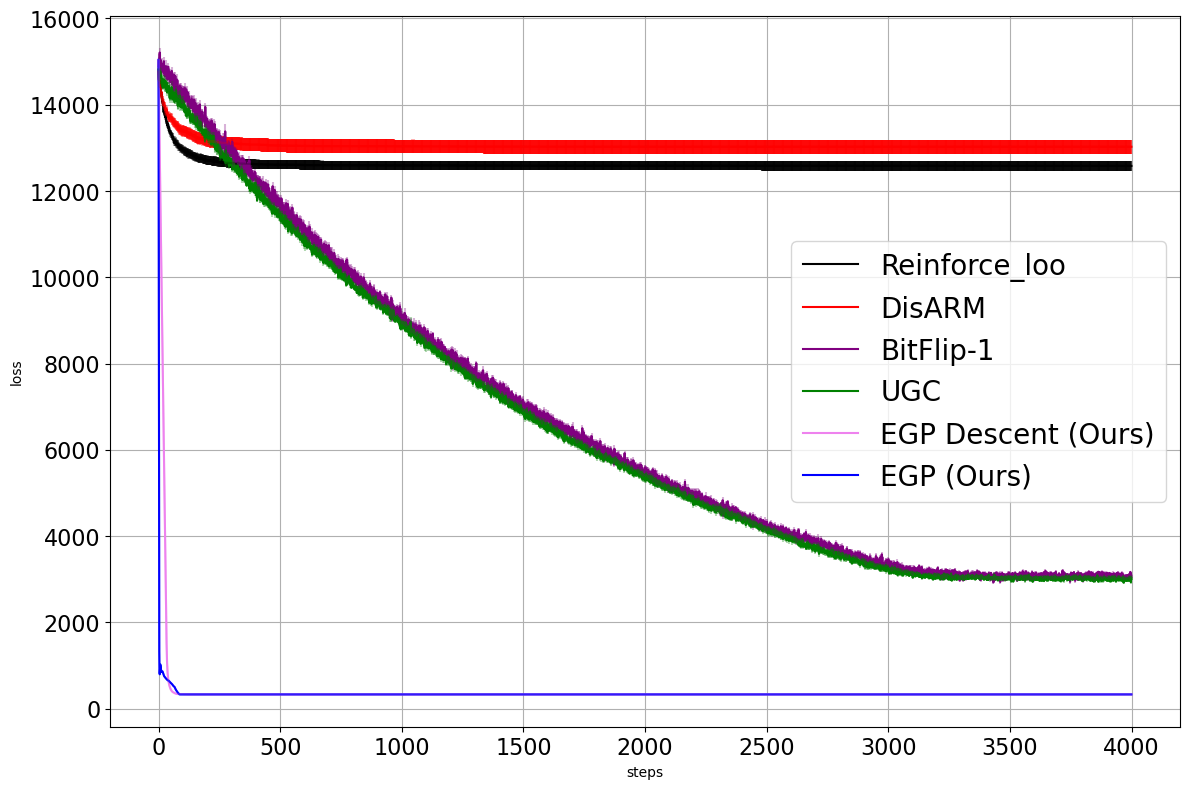

In [73]:

plt.figure(figsize = (12,8))
plt.errorbar(list(range(l_r.shape[1])),l_r.mean(axis = 0), l_r.std(axis = 0)/np.sqrt(10), alpha = 0.3, color = "black")
plt.plot(l_r.mean(axis = 0), color = "black", label = "Reinforce_loo")

plt.errorbar(list(range(l_d.shape[1])),l_d.mean(axis = 0), l_d.std(axis = 0)/np.sqrt(10),  alpha = 0.3, color = "red")
plt.plot(l_d.mean(axis = 0), color = "red", label = "DisARM")
plt.errorbar(list(range(l_b.shape[1])),l_b.mean(axis = 0), l_b.std(axis = 0)/np.sqrt(10),  alpha = 0.3, color = "purple")
plt.plot(l_b.mean(axis = 0), label = "BitFlip-1", color = "purple")
plt.errorbar(list(range(l_o.shape[1])),l_o.mean(axis = 0), l_o.std(axis = 0)/np.sqrt(10),  alpha = 0.3, color = "green")
plt.plot(l_o.mean(axis = 0), label = "UGC", color = "green")

plt.errorbar(list(range(l_e_descent.shape[1])),l_e_descent.mean(axis = 0), l_e_descent.std(axis = 0)/np.sqrt(10),  alpha = 0.3, color = "violet")
plt.plot(l_e_descent.mean(axis = 0), label = "EGP Descent (Ours)", color = "violet")

plt.errorbar(list(range(l_e.shape[1])),l_e.mean(axis = 0), l_e.std(axis = 0)/np.sqrt(10),  alpha = 0.3, color = "blue")
plt.plot(l_e.mean(axis = 0), label = "EGP (Ours)", color = "blue")

plt.ylabel("loss")
plt.xlabel("steps")
#plt.axhline(K*(t_**2), c = "black", linestyle ="--", label = "opt")
plt.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.legend(fontsize=20)
plt.grid()
plt.savefig("MonteCarloMethods_compared_with_EGP2.png", dpi = 300)

In [74]:
plt.savefig("MonteCarloMethods_compared_with_EGP2.svg")

<Figure size 640x480 with 0 Axes>

In [75]:
# generate metric table
# reconstruction_error, ASRE, final_L0_loss, t1-t0, final_beta
def compute_averages(*lists):
    triples = []
    
    for L in lists:
        # Extract first three elements from each tuple and compute averages
        M1 = sum(tuple[0] for tuple in L) / len(L)
        M2 = sum(tuple[1] for tuple in L) / len(L) 
        M3 = sum(tuple[2] for tuple in L) / len(L)
        M4 = sum(tuple[3] for tuple in L) / len(L)
        
        triples.append((M1, M3, M4, M2))
    
    return triples



In [76]:
import math

def compute_std_devs(*lists):
    std_devs = []
    
    for L in lists:
        # First compute means
        M1 = sum(tuple[0] for tuple in L) / len(L)
        M2 = sum(tuple[1] for tuple in L) / len(L) 
        M3 = sum(tuple[2] for tuple in L) / len(L)
        M4 = sum(tuple[3] for tuple in L) / len(L)
        
        # Then compute standard deviations
        S1 = math.sqrt(sum((tuple[0] - M1)**2 for tuple in L) / len(L))
        S2 = math.sqrt(sum((tuple[1] - M2)**2 for tuple in L) / len(L))
        S3 = math.sqrt(sum((tuple[2] - M3)**2 for tuple in L) / len(L))
        S4 = math.sqrt(sum((tuple[3] - M4)**2 for tuple in L) / len(L))
        
        std_devs.append((S1, S3, S4, S2))  # Same order as averages
    
    return std_devs

In [77]:
averaged_metrics = compute_averages(metrics_r, metrics_d, metrics_b, metrics_o)
averaged_metrics

[(np.float64(87.7070603501123),
  np.float64(12579.0),
  136.95402195453644,
  np.float64(839.8000149723246)),
 (np.float64(89.43622821914799),
  np.float64(13023.0),
  139.86691086292268,
  np.float64(873.4000741815338)),
 (np.float64(1130.4609702159296),
  np.float64(3060.2432768646822),
  112.15691630840301,
  np.float64(229.811150457748)),
 (np.float64(560.4163774072657),
  np.float64(3006.029930427897),
  188.06674020290376,
  np.float64(224.56411664845692))]

In [78]:
std_metrics = compute_std_devs(metrics_r, metrics_d, metrics_b, metrics_o)
std_metrics

[(3.7920856862980687,
  343.37879957854125,
  6.627761956272733,
  22.404451444446906),
 (3.0400646716156623, 507.0266265197519, 9.542553333176121, 32.29610751288281),
 (2251.075472760703, 156.67653543965818, 7.494377379968066, 2.217193796343839),
 (334.18770003151235,
  154.1130211400924,
  11.671308386087267,
  10.352083328927028)]

In [79]:
import pandas as pd

def combine_dataframes_with_triples(df1, df2, triples, 
                                   df1_name='df1', df2_name='df2', 
                                   df3_name='df3', df4_name='df4', 
                                   df5_name='df5', df6_name='df6', 
                                   df1_conv='df1', df2_conv='df2', 
                                   df3_conv='df3', df4_conv='df4', 
                                   df5_conv='df5', df6_conv='df6',
                                   ordering = ['average_rec_err', 'average_final_L0_loss', 'average_ASRE', 'average_runtime', 'Epochs_to_convergence']):
    col_names = [col for col in df1.columns]

    # Make copies to avoid modifying originals
    df1_copy = df1.copy()
    df2_copy = df2.copy()
    df3_copy = df1.copy()
    df4_copy = df2.copy()
    
    # Add triple values
    for i in range(len(triples)):
        df1_copy[col_names[i]] = triples[0][i]
        df2_copy[col_names[i]] = triples[1][i]
        df3_copy[col_names[i]] = triples[2][i]
        df4_copy[col_names[i]] = triples[3][i]
        
    # Add row identifier column
    df1['method'] = df1_name
    df2['method'] = df2_name
    df1_copy['method'] = df3_name
    df2_copy['method'] = df4_name
    df3_copy['method'] = df5_name
    df4_copy['method'] = df6_name

    df1['Epochs_to_convergence'] = df1_conv
    df2['Epochs_to_convergence'] = df2_conv
    df1_copy['Epochs_to_convergence'] = df3_conv
    df2_copy['Epochs_to_convergence'] = df4_conv
    df3_copy['Epochs_to_convergence'] = df5_conv
    df4_copy['Epochs_to_convergence'] = df6_conv
    
    # Combine with hierarchical index
    combined_df = pd.concat([df1_copy, df2_copy, df3_copy, df4_copy, df1, df2])
    combined_df = combined_df.set_index('method')
    combined_df = combined_df[ordering]
    return combined_df


In [84]:
results_table = combine_dataframes_with_triples(EGP_metrics, EGP_metrics_adam, averaged_metrics, 
                                   df1_name='EGP Descent (Ours)', df2_name='EGP (Ours)', 
                                   df3_name='Reinforce-Loo', df4_name='DisARM', 
                                   df5_name='Bitflip-1', df6_name='UGC', 
                                   df1_conv='150', df2_conv='100', 
                                   df3_conv='500', df4_conv='500', 
                                   df5_conv='3500', df6_conv='3500')
results_table

,average_rec_err,average_final_L0_loss,average_ASRE,average_runtime,Epochs_to_convergence
method,,,,,
Reinforce-Loo,87.707060,12579.000000,839.800015,136.954022,500
DisARM,89.436228,13023.000000,873.400074,139.866911,500
Bitflip-1,1130.460970,3060.243277,229.811150,112.156916,3500
UGC,560.416377,3006.029930,224.564117,188.066740,3500
EGP Descent (Ours),3.143917,22.932467,8.000000,5.380735,150
EGP (Ours),3.114097,22.931395,8.000000,7.904738,100


In [88]:
std_table = combine_dataframes_with_triples(EGP_metrics_std, EGP_metrics_std_adam, std_metrics, 
                                   df1_name='EGP Descent (Ours)', df2_name='EGP (Ours)', 
                                   df3_name='Reinforce-Loo', df4_name='DisARM', 
                                   df5_name='Bitflip-1', df6_name='UGC', 
                                   df1_conv='150', df2_conv='100', 
                                   df3_conv='500', df4_conv='500', 
                                   df5_conv='1500', df6_conv='1500', 
                                   ordering = ['std_rec_err', 'std_final_L0_loss', 'std_ASRE', 'std_runtime', 'Epochs_to_convergence'])
std_table

,std_rec_err,std_final_L0_loss,std_ASRE,std_runtime,Epochs_to_convergence
method,,,,,
Reinforce-Loo,3.792086e+00,343.378800,22.404451,6.627762,500
DisARM,3.040065e+00,507.026627,32.296108,9.542553,500
Bitflip-1,2.251075e+03,156.676535,2.217194,7.494377,1500
UGC,3.341877e+02,154.113021,10.352083,11.671308,1500
EGP Descent (Ours),0.000000e+00,0.000002,0.000000,0.108737,150
EGP (Ours),2.513152e-07,0.000000,0.000000,0.124162,100


In [89]:
# With better formatting options
latex_string = results_table.to_latex(
    index=True,           # Include row names
    escape=False,         # Don't escape LaTeX special characters
    float_format='%.3f',  # Format floats to 3 decimal places
    bold_rows=True        # Make row names bold
)
print(latex_string)

\begin{tabular}{lrrrrl}
\toprule
 & average_rec_err & average_final_L0_loss & average_ASRE & average_runtime & Epochs_to_convergence \\
method &  &  &  &  &  \\
\midrule
\textbf{Reinforce-Loo} & 87.707 & 12579.000 & 839.800 & 136.954 & 500 \\
\textbf{DisARM} & 89.436 & 13023.000 & 873.400 & 139.867 & 500 \\
\textbf{Bitflip-1} & 1130.461 & 3060.243 & 229.811 & 112.157 & 3500 \\
\textbf{UGC} & 560.416 & 3006.030 & 224.564 & 188.067 & 3500 \\
\textbf{EGP Descent (Ours)} & 3.144 & 22.932 & 8.000 & 5.381 & 150 \\
\textbf{EGP (Ours)} & 3.114 & 22.931 & 8.000 & 7.905 & 100 \\
\bottomrule
\end{tabular}



In [90]:
# With better formatting options
latex_string2 = std_table.to_latex(
    index=True,           # Include row names
    escape=False,         # Don't escape LaTeX special characters
    float_format='%.3f',  # Format floats to 3 decimal places
    bold_rows=True        # Make row names bold
)
print(latex_string2)

\begin{tabular}{lrrrrl}
\toprule
 & std_rec_err & std_final_L0_loss & std_ASRE & std_runtime & Epochs_to_convergence \\
method &  &  &  &  &  \\
\midrule
\textbf{Reinforce-Loo} & 3.792 & 343.379 & 22.404 & 6.628 & 500 \\
\textbf{DisARM} & 3.040 & 507.027 & 32.296 & 9.543 & 500 \\
\textbf{Bitflip-1} & 2251.075 & 156.677 & 2.217 & 7.494 & 1500 \\
\textbf{UGC} & 334.188 & 154.113 & 10.352 & 11.671 & 1500 \\
\textbf{EGP Descent (Ours)} & 0.000 & 0.000 & 0.000 & 0.109 & 150 \\
\textbf{EGP (Ours)} & 0.000 & 0.000 & 0.000 & 0.124 & 100 \\
\bottomrule
\end{tabular}

